# Bikeshare Submission

## Packages Used

In [1]:
import pandas as pd
# from ydata_profiling import ProfileReport
import os

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
- datetime - hourly date + timestamp  
- season 
    - 1 = spring, 
    - 2 = summer, 
    - 3 = fall, 
    - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals <- PREDICTION

# Extracting the Train and Test Data

In [2]:
train_df = pd.read_csv('../data/train.csv')

# Dropping casual and registered columns
train_df.drop(['casual', 'registered'], axis=1, inplace=True)

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [3]:
test_df = pd.read_csv('../data/test.csv')
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## - Inspecting Null Values

In [4]:
test_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## - Inspecting Distribution and Correlation

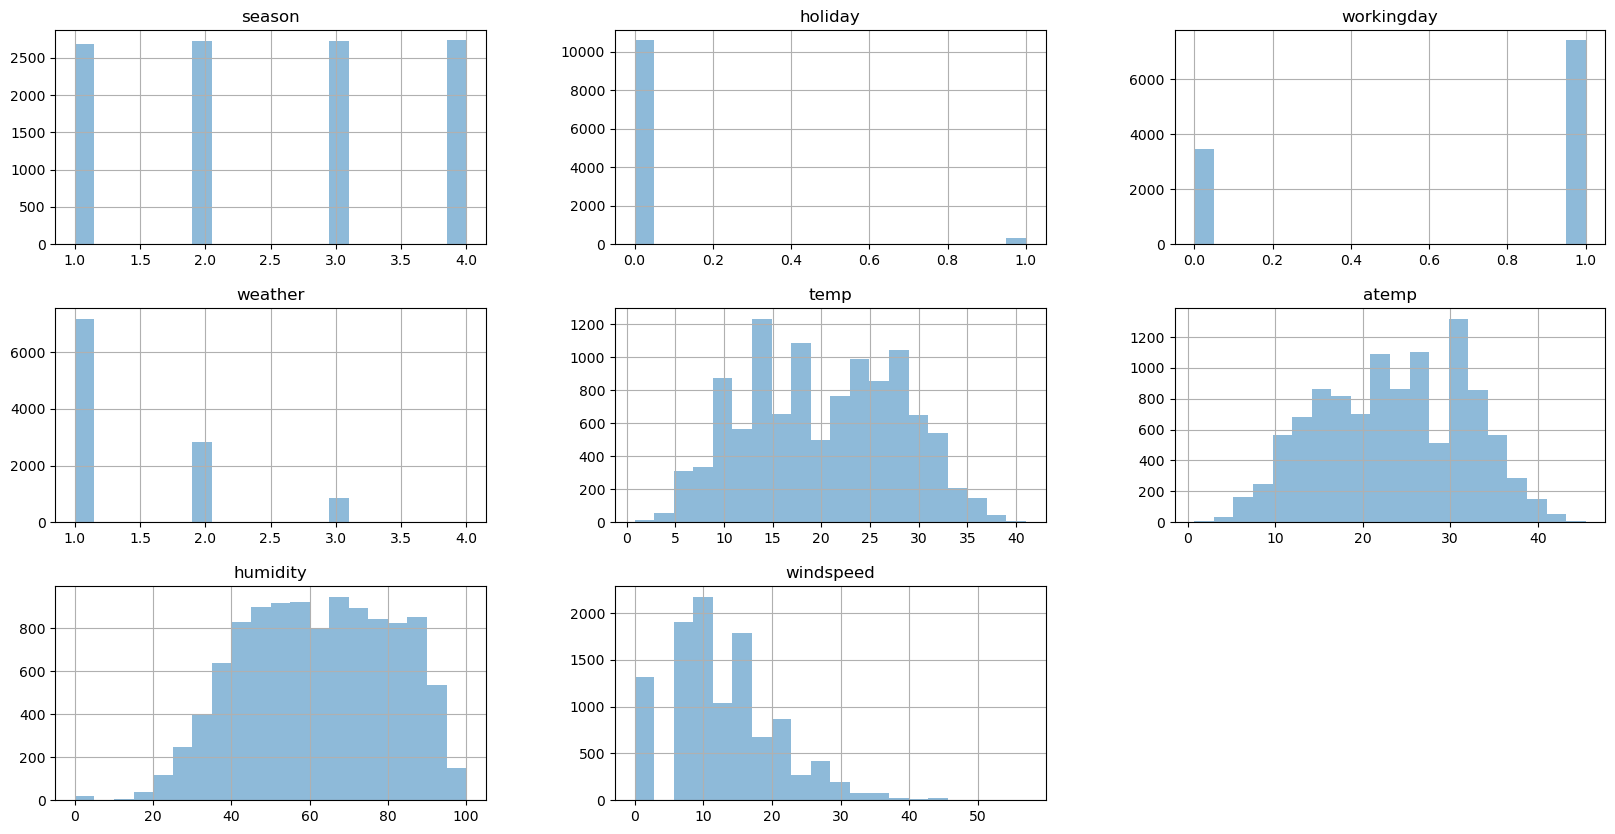

In [66]:
_ = train_df.drop(columns=["count"]).hist(figsize=(20, 10), bins=20, alpha=0.5)

In [74]:
# Create heatmap of correlations
train_df.drop(columns=["datetime"]).corr().style.background_gradient(cmap='coolwarm')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


# Generate the profile report

In [62]:
# profile_df = pd.concat([train_df.drop(columns=["count"]), test_df], axis=0)

In [60]:
# profile = ProfileReport(profile_df, title='Pandas Profiling Report', explorative=True)

In [61]:
# profile.to_file("./reports/eda-profile.html")
# _ = os.system("open ./reports/eda-profile.html")

# Training without Using Data Engineering

In [37]:
from autogluon.tabular import TabularPredictor

## - Training without New Features

In [38]:
predictor = TabularPredictor(
        label='count',
        path='autogluon',
        eval_metric='root_mean_squared_error',
    ).fit(
        train_df,
        time_limit=600,
        presets='best_quality'
    )

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:12:58 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       3.89 GB / 16.00 GB (24.3%)
Disk Space Avail:   39.28 GB / 460.43 GB (8.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then

KeyboardInterrupt: 

## - Showing the Leatherboard

In [40]:
try:
    display(predictor.leaderboard(silent=True))
except:
    predictor = TabularPredictor.load('autogluon')
    display(predictor.leaderboard(silent=True))

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-54.569714,root_mean_squared_error,1.292876,443.947090,0.000248,0.011255,3,True,9
1,LightGBM_BAG_L2,-54.586355,root_mean_squared_error,1.010519,318.299719,0.039332,20.634286,2,True,8
2,LightGBMXT_BAG_L2,-60.570375,root_mean_squared_error,1.253296,423.301549,0.282109,125.636116,2,True,7
3,KNeighborsDist_BAG_L1,-84.146423,root_mean_squared_error,0.014645,0.009696,0.014645,0.009696,1,True,2
4,WeightedEnsemble_L2,-84.146423,root_mean_squared_error,0.014847,0.021625,0.000202,0.011929,2,True,6
5,KNeighborsUnif_BAG_L1,-101.588176,root_mean_squared_error,0.014143,0.006946,0.014143,0.006946,1,True,1
6,RandomForestMSE_BAG_L1,-116.542032,root_mean_squared_error,0.241228,1.870387,0.241228,1.870387,1,True,5
7,LightGBM_BAG_L1,-131.432362,root_mean_squared_error,0.088231,39.867387,0.088231,39.867387,1,True,4
8,LightGBMXT_BAG_L1,-131.494795,root_mean_squared_error,0.612940,255.911016,0.612940,255.911016,1,True,3


## - Predictions on Test Data

In [41]:
predictions = predictor.predict(test_df)
predictions.head()

0    34.273094
1    43.230057
2    46.590622
3    50.979973
4    51.777607
Name: count, dtype: float32

In [42]:
# Identifying negative predictions
predictions.describe()

count    6493.000000
mean       98.326591
std        88.796036
min       -10.711480
25%        16.453503
50%        62.550030
75%       169.153320
max       370.938568
Name: count, dtype: float64

In [43]:
# Counting negative predictions
negative_prediction_count = (predictions < 0).sum()

print(f"There are {negative_prediction_count} negative predictions to set to zero.")

There are 9 negative predictions to set to zero.


## - Setting up for Submission

In [44]:
# Setting negative predictions to zero
predictions[predictions < 0] = 0

predictions.describe()

count    6493.000000
mean       98.332489
std        88.789307
min         0.000000
25%        16.453503
50%        62.550030
75%       169.153320
max       370.938568
Name: count, dtype: float64

In [45]:
submission_df = pd.read_csv('../data/sampleSubmission.csv')
display(submission_df.head())
submission_df.shape

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


(6493, 2)

In [46]:
submission_df['count'] = predictions
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())
submission_df.shape

,datetime,count
0,2011-01-20 00:00:00,34.273094
1,2011-01-20 01:00:00,43.230057
2,2011-01-20 02:00:00,46.590622
3,2011-01-20 03:00:00,50.979973
4,2011-01-20 04:00:00,51.777607


(6493, 2)

## - Submitting Initial Predictions

In [47]:
# Getting the best model name
best_model = predictor.model_best
best_model

'WeightedEnsemble_L3'

In [34]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m f"irst submission with {best_model}"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 436kB/s]
Successfully submitted to Bike Sharing Demand

In [35]:
!kaggle competitions submissions -c bike-sharing-demand

fileName        date                 description                                status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------  --------  -----------  ------------  
submission.csv  2024-07-07 21:14:45  first submission with WeightedEnsemble_L3  complete  1.84764      1.84764       


# Training with Feature Engineering

## - Transforming Features as Categories

In [83]:
# Converting to categorical for better performance
train_df["season"] = train_df["season"].astype("category")
train_df["weather"] = train_df["weather"].astype("category")
test_df["season"] = test_df["season"].astype("category")
test_df["weather"] = test_df["weather"].astype("category")

##  - Inspecting Distribution and Correlation

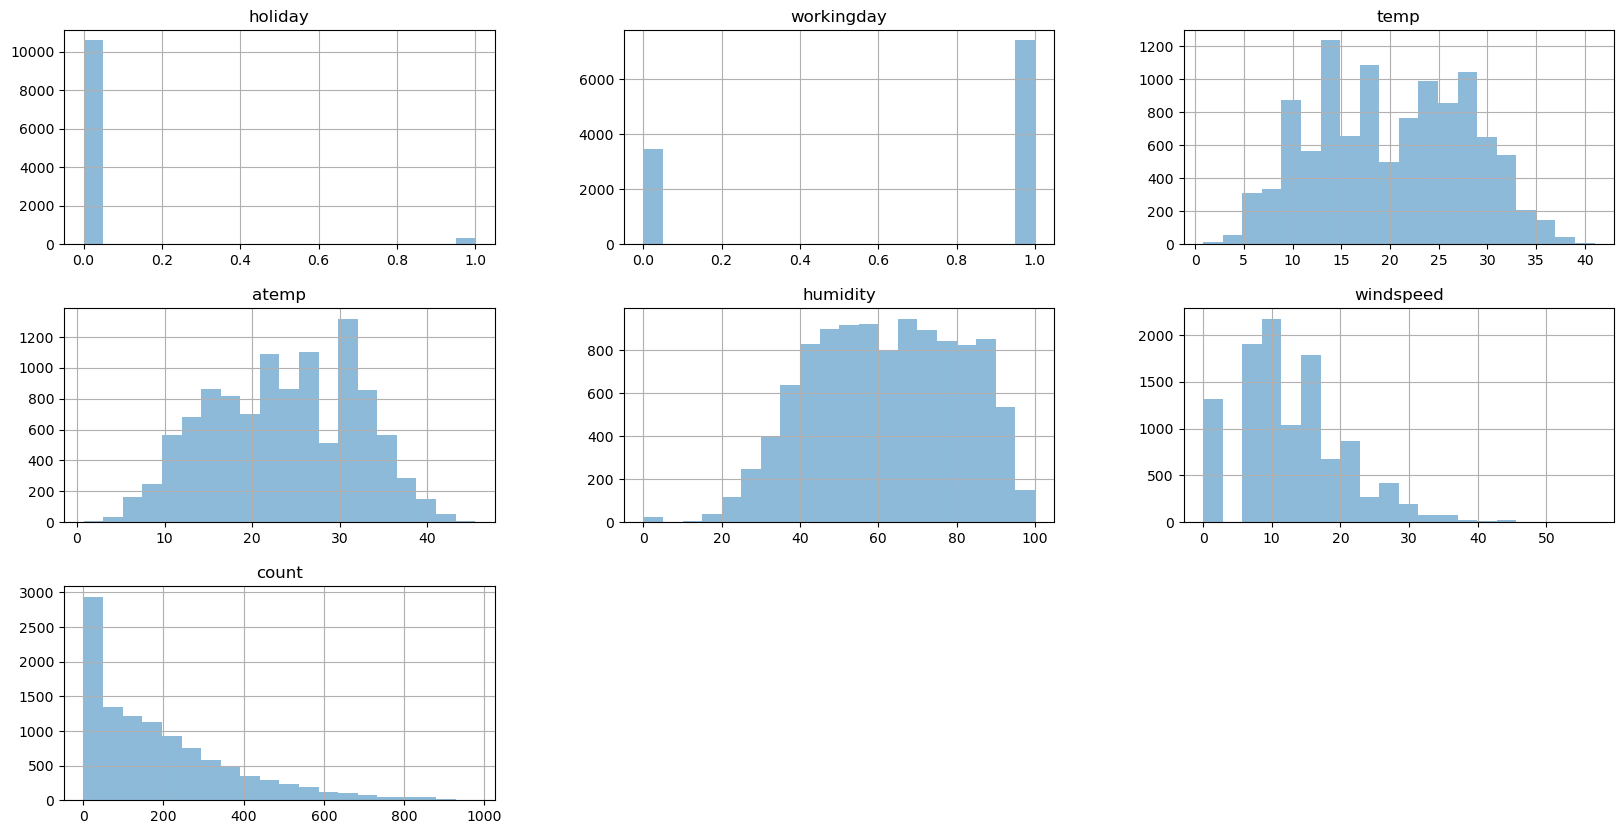

In [84]:
# View histograms
_ = train_df.hist(figsize=(20, 10), bins=20, alpha=0.5)

In [85]:
correlation_df = train_df.drop(columns=["datetime"]).corr()
correlation_df.style.background_gradient(cmap='coolwarm')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [109]:
# Identify correlation higher than 0.9
correlation_threshold = 0.9
correlation_matrix = correlation_df.abs() > correlation_threshold

# Find pairs of features with high correlation
correlation_matrix = correlation_matrix.stack()
correlation_matrix = correlation_matrix[correlation_matrix]
correlation_matrix = correlation_matrix.reset_index()
correlation_matrix.columns = ["Feature 1", "Feature 2", "Correlation"]

# Where Feature 1 is not equal to Feature 2
correlation_matrix = correlation_matrix[correlation_matrix["Feature 1"] != correlation_matrix["Feature 2"]]
display(correlation_matrix)

# Identify which feature correlates more with count
correlation_with_count = correlation_df["count"].abs().sort_values(ascending=False)
correlation_with_count.to_frame().style.background_gradient(cmap='hot')

,Feature 1,Feature 2,Correlation
5,temp,atemp,True
6,atemp,temp,True


,count
count,1.000000
temp,0.394454
atemp,0.389784
humidity,0.317371
season,0.163439
weather,0.128655
windspeed,0.101369
workingday,0.011594
holiday,0.005393


## - Re-training the model with categorical columns

In [86]:
predictor_new_features = TabularPredictor(
    label='count',
    path='autogluon-new-features',
    eval_metric='root_mean_squared_error',
).fit(
    train_df,
    time_limit=600,
    presets='best_quality'
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.5.0: Wed May  1 20:12:58 PDT 2024; root:xnu-10063.121.3~5/RELEASE_ARM64_T6000
CPU Count:          8
Memory Avail:       3.77 GB / 16.00 GB (23.6%)
Disk Space Avail:   38.90 GB / 460.43 GB (8.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then

[1000]	valid_set's rmse: 129.884
[2000]	valid_set's rmse: 129.338
[1000]	valid_set's rmse: 129.41
[2000]	valid_set's rmse: 128.542
[1000]	valid_set's rmse: 132.736
[2000]	valid_set's rmse: 132.145
[1000]	valid_set's rmse: 126.902
[2000]	valid_set's rmse: 125.608
[3000]	valid_set's rmse: 125.013
[1000]	valid_set's rmse: 134.952
[2000]	valid_set's rmse: 134.183
[3000]	valid_set's rmse: 133.455
[4000]	valid_set's rmse: 133.177
[5000]	valid_set's rmse: 132.541
[6000]	valid_set's rmse: 132.433


	Ran out of time, early stopping on iteration 6371. Best iteration is:
	[6303]	valid_set's rmse: 132.303


[1000]	valid_set's rmse: 137.272
[2000]	valid_set's rmse: 135.531
[3000]	valid_set's rmse: 134.963
[4000]	valid_set's rmse: 134.68


	Ran out of time, early stopping on iteration 4317. Best iteration is:
	[4013]	valid_set's rmse: 134.644


[1000]	valid_set's rmse: 138.333


	Ran out of time, early stopping on iteration 1469. Best iteration is:
	[1454]	valid_set's rmse: 137.466
	-131.5702	 = Validation score   (-root_mean_squared_error)
	93.49s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 5.08s of the 55.07s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 135. Best iteration is:
	[133]	valid_set's rmse: 133.151
	Ran out of time, early stopping on iteration 139. Best iteration is:
	[139]	valid_set's rmse: 131.762
	Ran out of time, early stopping on iteration 147. Best iteration is:
	[146]	valid_set's rmse: 134.477
	Ran out of time, early stopping on iteration 144. Best iteration is:
	[144]	valid_set's rmse: 133.458
	Ran out of time, early stopping on iteration 163. Best iteration is:
	[163]	valid_set's rmse: 129.419
	Ran out of time, early stopping on iteration 177. Best iteration is:
	[176

[1000]	valid_set's rmse: 67.7535
[1000]	valid_set's rmse: 71.466
[1000]	valid_set's rmse: 77.4934


	Ran out of time, early stopping on iteration 1886. Best iteration is:
	[1475]	valid_set's rmse: 77.3103


[1000]	valid_set's rmse: 73.0181


	Ran out of time, early stopping on iteration 1694. Best iteration is:
	[1307]	valid_set's rmse: 72.7247


[1000]	valid_set's rmse: 77.2509
[2000]	valid_set's rmse: 77.213
[1000]	valid_set's rmse: 76.8031
[1000]	valid_set's rmse: 71.208
[1000]	valid_set's rmse: 74.4012
[2000]	valid_set's rmse: 74.0819


	-73.4828	 = Validation score   (-root_mean_squared_error)
	38.79s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 8.77s of the 8.75s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 270. Best iteration is:
	[138]	valid_set's rmse: 62.1571
	Ran out of time, early stopping on iteration 282. Best iteration is:
	[142]	valid_set's rmse: 64.232
	Ran out of time, early stopping on iteration 255. Best iteration is:
	[140]	valid_set's rmse: 69.0506
	Ran out of time, early stopping on iteration 305. Best iteration is:
	[201]	valid_set's rmse: 68.6755
	Ran out of time, early stopping on iteration 321. Best iteration is:
	[120]	valid_set's rmse: 68.2802
	Ran out of time, early stopping on iteration 346. Best iteration is:
	[124]	valid_set's rmse: 70.9228
	Ran out of time, early stopping on iteration 386. Best iteration is:
	[129]	va

[1000]	valid_set's rmse: 130.813
[2000]	valid_set's rmse: 130.277


	Ran out of time, early stopping on iteration 2124. Best iteration is:
	[1761]	valid_set's rmse: 130.15


[1000]	valid_set's rmse: 135.055
[1000]	valid_set's rmse: 132.863
[2000]	valid_set's rmse: 131.927


	Ran out of time, early stopping on iteration 2457. Best iteration is:
	[2451]	valid_set's rmse: 131.675


[1000]	valid_set's rmse: 127.258
[2000]	valid_set's rmse: 126.566


	Ran out of time, early stopping on iteration 2519. Best iteration is:
	[2492]	valid_set's rmse: 126.443


[1000]	valid_set's rmse: 133.682
[2000]	valid_set's rmse: 132.057
[3000]	valid_set's rmse: 130.996


	Ran out of time, early stopping on iteration 3912. Best iteration is:
	[3830]	valid_set's rmse: 130.56


[1000]	valid_set's rmse: 134.515
[2000]	valid_set's rmse: 133.869
[1000]	valid_set's rmse: 133.908
[2000]	valid_set's rmse: 132.57
[3000]	valid_set's rmse: 132.156
[4000]	valid_set's rmse: 131.909
[5000]	valid_set's rmse: 131.895
[1000]	valid_set's rmse: 132.398
[2000]	valid_set's rmse: 131.476
[3000]	valid_set's rmse: 131.125
[4000]	valid_set's rmse: 131.208
[5000]	valid_set's rmse: 131.066
[6000]	valid_set's rmse: 131.115


	-131.3015	 = Validation score   (-root_mean_squared_error)
	252.02s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 45.89s of the 195.67s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 432. Best iteration is:
	[426]	valid_set's rmse: 130.478


[1000]	valid_set's rmse: 133.028
[1000]	valid_set's rmse: 131.187
[1000]	valid_set's rmse: 126.598
[1000]	valid_set's rmse: 130.79
[2000]	valid_set's rmse: 130.757
[1000]	valid_set's rmse: 133.168
[1000]	valid_set's rmse: 131.157
[1000]	valid_set's rmse: 130.666


	-130.7397	 = Validation score   (-root_mean_squared_error)
	34.12s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 11.3s of the 161.07s of remaining time.
	-116.6309	 = Validation score   (-root_mean_squared_error)
	1.66s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 9.15s of the 158.92s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 375.
	Ran out of time, early stopping on iteration 414.
	Ran out of time, early stopping on iteration 422.
	Ran out of time, early stopping on iteration 427.
	Ran out of time, early stopping on iteration 417.
	Ran out of time, early stopping on iteration 469.
	Ran out of time, early stopping on iteration 512.
	Ran out of time, early stopping on iteration 613.
	-136.1294	 = Validation score   (-root_mean_squared_error)


[1000]	valid_set's rmse: 61.5997
[2000]	valid_set's rmse: 60.5465
[1000]	valid_set's rmse: 60.9525
[2000]	valid_set's rmse: 59.5735
[1000]	valid_set's rmse: 63.9217
[2000]	valid_set's rmse: 62.6126
[1000]	valid_set's rmse: 63.5466
[2000]	valid_set's rmse: 62.6229
[1000]	valid_set's rmse: 58.3412
[2000]	valid_set's rmse: 57.0796
[1000]	valid_set's rmse: 62.8921
[2000]	valid_set's rmse: 61.8704
[3000]	valid_set's rmse: 62.0382
[1000]	valid_set's rmse: 64.4288
[2000]	valid_set's rmse: 63.7549
[1000]	valid_set's rmse: 58.7149
[2000]	valid_set's rmse: 58.0931


	-60.7416	 = Validation score   (-root_mean_squared_error)
	65.28s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 82.75s of the 82.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-54.6821	 = Validation score   (-root_mean_squared_error)
	16.15s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 66.5s of the 66.48s of remaining time.
	-53.0126	 = Validation score   (-root_mean_squared_error)
	5.13s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 60.88s of the 60.86s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 2369.
	-55.2169	 = Validation score   (-root_mean_squared_error)
	49.99s	 = Training   runtime
	0.02s	 = Validation run

## - Showing the Leatherboard

In [87]:
try:
    display(predictor_new_features.leaderboard(silent=True))
except:
    predictor_new_features = TabularPredictor.load('autogluon-new-features')
    display(predictor_new_features.leaderboard(silent=True))

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-52.509594,root_mean_squared_error,1.734140,369.858831,0.000209,0.014574,3,True,15
1,RandomForestMSE_BAG_L2,-53.012627,root_mean_squared_error,1.400775,302.380536,0.279177,5.125411,2,True,11
2,ExtraTreesMSE_BAG_L2,-53.647904,root_mean_squared_error,1.397926,298.586987,0.276328,1.331862,2,True,13
3,LightGBM_BAG_L2,-54.682144,root_mean_squared_error,1.162112,313.400169,0.040514,16.145044,2,True,10
4,CatBoost_BAG_L2,-55.216856,root_mean_squared_error,1.137912,347.241940,0.016314,49.986816,2,True,12
5,LightGBMXT_BAG_L2,-60.741570,root_mean_squared_error,1.396845,362.531581,0.275247,65.276457,2,True,9
6,NeuralNetFastAI_BAG_L2,-82.408300,root_mean_squared_error,1.325884,305.257513,0.204286,8.002388,2,True,14
7,KNeighborsDist_BAG_L1,-84.146423,root_mean_squared_error,0.014512,0.005741,0.014512,0.005741,1,True,2
8,WeightedEnsemble_L2,-84.146423,root_mean_squared_error,0.015391,0.016189,0.000879,0.010448,2,True,8
9,KNeighborsUnif_BAG_L1,-101.588176,root_mean_squared_error,0.015999,0.006527,0.015999,0.006527,1,True,1


## - Predictions on Test Data

In [88]:
predictions_new_features = predictor_new_features.predict(test_df)

## - Setting up for Submission

In [89]:
# Setting negative predictions to zero
predictions_new_features[predictions_new_features < 0] = 0

In [90]:
submission_new_features_df = pd.read_csv('../data/sampleSubmission.csv')
submission_new_features_df['count'] = predictions_new_features
submission_new_features_df.to_csv('submission-new-features.csv', index=False)

In [94]:
# Compare old and new submissions
submission_df = pd.read_csv('submission.csv')
submission_new_features_df = pd.read_csv('submission-new-features.csv')

submission_df.merge(submission_new_features_df, on='datetime', suffixes=('_old', '_new'))

,datetime,count_old,count_new
0,2011-01-20 00:00:00,34.273094,23.911224
1,2011-01-20 01:00:00,43.230057,42.881252
2,2011-01-20 02:00:00,46.590622,47.045166
3,2011-01-20 03:00:00,50.979973,49.280098
4,2011-01-20 04:00:00,51.777607,51.790570
...,...,...,...
6488,2012-12-31 19:00:00,168.921830,158.083010
6489,2012-12-31 20:00:00,168.921830,158.083010
6490,2012-12-31 21:00:00,169.793330,148.362730
6491,2012-12-31 22:00:00,167.674060,144.396210


## - Submitting New Predictions

In [95]:
best_model = predictor_new_features.model_best
best_model

'WeightedEnsemble_L3'

In [96]:
!kaggle competitions submit -c bike-sharing-demand -f submission-new-features.csv -m "new features with {best_model}"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 436kB/s]
Successfully submitted to Bike Sharing Demand

In [97]:
!kaggle competitions submissions -c bike-sharing-demand

fileName                     date                 description                                status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------------  --------  -----------  ------------  
submission-new-features.csv  2024-07-08 23:47:44  new features with WeightedEnsemble_L3      complete  1.7966       1.7966        
submission.csv               2024-07-07 21:14:45  first submission with WeightedEnsemble_L3  complete  1.84764      1.84764       


# Training with Hyperparameter Tuning
The following documentation show how to train a model with hyperparameter tuning using AutoGluon.

Documentation: https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.fit.html

## - Inspecting And Removing High Correlation Features

In [5]:
correlation_df = train_df.drop(columns=["datetime"]).corr()
correlation_df.style.background_gradient(cmap='coolwarm')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000


In [6]:
# Identify correlation higher than 0.9
correlation_threshold = 0.9
correlation_matrix = correlation_df.abs() > correlation_threshold

# Find pairs of features with high correlation
correlation_matrix = correlation_matrix.stack()
correlation_matrix = correlation_matrix[correlation_matrix]
correlation_matrix = correlation_matrix.reset_index()
correlation_matrix.columns = ["Feature 1", "Feature 2", "Correlation"]

# Where Feature 1 is not equal to Feature 2
correlation_matrix = correlation_matrix[correlation_matrix["Feature 1"] != correlation_matrix["Feature 2"]]
display(correlation_matrix)

# Identify which feature correlates more with count
correlation_with_count = correlation_df["count"].abs().sort_values(ascending=False)
correlation_with_count.to_frame().style.background_gradient(cmap='hot')

,Feature 1,Feature 2,Correlation
5,temp,atemp,True
6,atemp,temp,True


,count
count,1.000000
temp,0.394454
atemp,0.389784
humidity,0.317371
season,0.163439
weather,0.128655
windspeed,0.101369
workingday,0.011594
holiday,0.005393


In [7]:
# Dropping attemp since it is highly correlated with temp and it is less correlated with count
train_df.drop(columns=["atemp"], inplace=True)
test_df.drop(columns=["atemp"], inplace=True)

## - One Hot Encoding for Categorical Features

In [8]:
# One hot encoding
train_df = pd.get_dummies(train_df, columns=["season", "weather"])
test_df = pd.get_dummies(test_df, columns=["season", "weather"])

## - Creating a Validation Set

In [9]:
from sklearn.model_selection import train_test_split

train_val_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(""" 
Train shape: {train_val_df.shape}
Validation shape: {test_val_df.shape}    
""")

train_val_df.head()

 
Train shape: {train_val_df.shape}
Validation shape: {test_val_df.shape}    



,datetime,holiday,workingday,temp,humidity,windspeed,count,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
2815,2011-07-06 05:00:00,0,1,27.88,83,6.0032,35,False,False,True,False,True,False,False,False
8695,2012-08-04 16:00:00,0,0,36.90,39,19.9995,450,False,False,True,False,True,False,False,False
8406,2012-07-11 15:00:00,0,1,32.80,41,16.9979,276,False,False,True,False,True,False,False,False
1543,2011-04-10 04:00:00,0,0,14.76,93,7.0015,5,False,True,False,False,False,True,False,False
4952,2011-11-19 10:00:00,0,0,13.12,45,16.9979,200,False,False,False,True,True,False,False,False


## - Re-train with One Hot Encoding & Hyperparameter Tuning

In [53]:
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config
from autogluon.tabular import TabularPredictor
from autogluon.common import space

In [61]:
hyperparameters = {
    'XGB': {
        'learning_rate': space.Real(0.01, 0.1, 0.2),  # Use a single, common value initially
    }
}


hyper_timeout = 2*60  # seconds
time_limit = hyper_timeout * 1.5  # 1.5x the hyperparameter optimization time
print(f"Hyperparameter optimization time: {hyper_timeout/60} minutes")
print(f"Time limit: {time_limit/60} minutes")

# Custom hyperparameter tuning configuration
hyperparameter_tune_kwargs = {
    'num_trials': 10,  # Number of trials to run
    'scheduler': 'local',  # Scheduler to use for parallel training
    'searcher': 'bayes',  # Searcher to use for hyperparameter optimization
    'time_out': hyper_timeout,  # Time limit in seconds for each call to the ML model
}

predictor_new_hpo = TabularPredictor(
    label='count',
    path='autogluon-new-hpo',
    eval_metric='root_mean_squared_error'    
)

predictor_new_hpo.fit(
    train_val_df,
    time_limit=time_limit,
    presets='best_quality',
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
    num_cpus=6,
    num_gpus=1,
    num_bag_folds=2,
    num_stack_levels=3,
    verbosity=1
)

/Users/samuel/anaconda3/envs/bikeshare/lib/python3.11/site-packages/autogluon/tabular/predictor/predictor.py:1242: UserWarning: Failed to use ray for memory safe fits. Falling back to normal fit. Error: ValueError('ray==2.31.0 detected. 2.10.0 <= ray < 2.11.0 is required. You can use pip to install certain version of ray `pip install ray==2.10.0` ')
  stacked_overfitting = self._sub_fit_memory_save_wrapper(
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead


Hyperparameter optimization time: 2.0 minutes
Time limit: 3.0 minutes


 80%|████████  | 8/10 [01:54<00:28, 14.32s/it]
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
 90%|█████████ | 9/10 [01:54<00:12, 12.75s/it]


In [62]:
predictor_new_hpo.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L5,-131.643153,root_mean_squared_error,0.156293,56.290463,0.000164,0.010725,5,True,12
1,WeightedEnsemble_L2,-131.643153,root_mean_squared_error,0.156341,56.287472,0.000212,0.007735,2,True,11
2,XGBoost_BAG_L1/T3,-132.458895,root_mean_squared_error,0.033357,12.618010,0.033357,12.618010,1,True,3
3,XGBoost_BAG_L1/T7,-132.716441,root_mean_squared_error,0.032512,13.153260,0.032512,13.153260,1,True,7
4,XGBoost_BAG_L1/T5,-132.853653,root_mean_squared_error,0.018771,10.386153,0.018771,10.386153,1,True,5
5,XGBoost_BAG_L1/T2,-133.290816,root_mean_squared_error,0.040163,10.630394,0.040163,10.630394,1,True,2
6,XGBoost_BAG_L1/T8,-133.635584,root_mean_squared_error,0.031326,9.491921,0.031326,9.491921,1,True,8
7,XGBoost_BAG_L1/T1,-134.026275,root_mean_squared_error,0.015909,5.947566,0.015909,5.947566,1,True,1
8,XGBoost_BAG_L1/T10,-134.183807,root_mean_squared_error,0.038696,6.406397,0.038696,6.406397,1,True,10
9,XGBoost_BAG_L1/T9,-134.557739,root_mean_squared_error,0.050564,12.480267,0.050564,12.480267,1,True,9


In [59]:
performance = predictor_new_hpo.evaluate(val_df)
performance

{'root_mean_squared_error': -130.0163796138821,
 'mean_squared_error': -16904.258967901093,
 'mean_absolute_error': -91.77249183492775,
 'r2': 0.4878573692201654,
 'pearsonr': 0.6994652755972876,
 'median_absolute_error': -65.7849006652832}

In [49]:
predictions_new_hpo = predictor_new_hpo.predict(val_df)

Loading: autogluon-new-hpo/models/XGBoost_BAG_L1/T1/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L1/T2/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L1/T3/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L1/T4/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L1/T5/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L2/T3/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L2/T5/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L2/T6/model.pkl
Loading: autogluon-new-hpo/models/XGBoost_BAG_L2/T7/model.pkl
Loading: autogluon-new-hpo/models/WeightedEnsemble_L3/model.pkl


In [50]:
predictions_new_hpo

3133     205.536255
5786      53.796410
5224      90.775894
8953     355.793854
8054     259.267914
            ...    
1963     340.718140
5807      99.904152
10061    438.173096
5427      52.141018
7588     204.310898
Name: count, Length: 2178, dtype: float32

In [51]:
# Calculating scores of predictions
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(val_df["count"], predictions_new_hpo)

1.5207634536469345

# END OF NOTEBOOK